# YT 2020: MSTAT Production

Перепроверить расчеты можно тут https://yt.yandex-team.ru/hahn/resource-planner/ 

In [5]:
# обязательный импорт для каждого питонячего ноутбука
PATH_REGEXP = r'(preorder/v\d+apr)'
DEFAULT_KEY = None#'ent_test'
import os
import re
import sys
import logging
from pathlib import Path
cwd = os.getcwd()
preorder_key = max(re.findall(PATH_REGEXP, cwd))
capacity_path = Path(cwd[:cwd.rfind(preorder_key)])
sys.path.extend([str(capacity_path), str(capacity_path / preorder_key), str(capacity_path / ("../" * 4))])
import market.sre.tools.capacity.lib.tools as tools


In [2]:
import pandas as pd
import numpy as np
from pprint import pformat
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

import warnings
warnings.simplefilter("ignore", UserWarning)

In [4]:
from market.sre.tools.capacity.lib.YT.Cluster import Cluster
from market.sre.tools.capacity.lib.tools import today
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.predictor import Formula, Feature, FormulaStrategy, Predictor, Window
from market.sre.tools.capacity.preorder.v2020apr.input_data.YT_accounts import arnold_accounts, hahn_accounts, seneca_sas_accounts, seneca_man_accounts, seneca_vla_accounts
from market.sre.tools.capacity.preorder.v2020apr.input_data.YT_pools import hahn_pools_list, hahn_pools_dict, arnold_pools_list, arnold_pools_dict
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.disk_forecaster import get_disk_forecast
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.cpu_forecaster import get_cpu_forecast
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.yt.yt_order import YTOrderRequestFile, YTOrderRequestFileItem, YtOrderRequestFileItemDiskQuota, YtOrderRequestFileItemCpuQuota, YtOrderRequestFileItemDTQuota
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.department import Department
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.department_info import DepartmentInfo
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.cloud import Cloud
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.reason import Reason
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.deadline import Deadline
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.types.platform import Platform
from market.sre.tools.capacity.preorder.v2020apr.preorder_lib.core.resources_info import ResourcesInfo
from market.sre.tools.capacity.preorder.v2020apr.additional.YT.tools import clean_YT_account

## Настройки

In [3]:
# paramaters add tag here
forecast_start_date = "2020-07-01"
forecast_end_date = "2020-08-01"
history_start_date = "2020-04-01"
history_end_date = "2020-05-01"
dau_white = 5500000
dau_blue = 4000000
offers_white = 2000000
offers_blue = 0
orders_blue = 0
dc_minus_one = True
gencfg_dir = '2020-05'
service_file_name='indexer'
department='INDEXER'
service_key_words = ['indexer']
preorder_id='aug20'
out_dir='out/yt'
revision_number='current'
kpi_key=None

In [4]:
# откуда смотреть историю потребления
date_start = history_start_date
date_end =history_end_date
forecast_date = forecast_end_date
result_dir = out_dir
start_key=kpi_key
tools.set_start_key(start_key)
target_dir = capacity_path / preorder_key / f"additional/RTC/src/{out_dir}/{revision_number}/dataframes"

# verbose
verbose = True

# учитывать ли пики в пуле?
consider_peaks = False

# grid
grid=True

tail_depth = 7
quantile = .8

# formula
formula = None

# formula stratery
formula_strategy = FormulaStrategy.FIRST

# настройки Predictor'а
decreasing_base_function = 'mean'
decreasing_reserve = 1
features = [Feature.DAU, Feature.OFFERS_COUNT]

# defaults
default_platform = Platform.INFRA
default_department = Department.MSTAT

notebook_filename = f"https://a.yandex-team.ru/arc/trunk/arcadia/market/sre/tools/capacity/{preorder_key}/additional/FORECAST/YT/mstat_testing.ipynb"
notebook_filename

NameError: name 'tools' is not defined

In [7]:
whois = ResourcesInfo(capacity_path / preorder_key / "input_data/files/whois", default_platform=default_platform, default_department=default_department)

In [8]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

grid = True

In [9]:
predictor = Predictor()

### Env

In [10]:
env = 'production'

## Disk

#### Accounts

In [11]:
labels = 'mst', 'analyst'

_hahn_accounts = [account for account in arnold_accounts if (labels[0] in account or labels[1] in account) and account not in [account for account in hahn_accounts if (labels[0] in account or labels[1] in account) and env in account] + ['logfeller-market']]
_arnold_accounts = [account for account in arnold_accounts if (labels[0] in account or labels[1] in account) and account not in [account for account in arnold_accounts if (labels[0] in account or labels[1] in account) and env in account] + ['logfeller-market']]
_seneca_sas_accounts = [account for account in seneca_sas_accounts if (labels[0] in account or labels[1] in account) not in [account for account in seneca_sas_accounts if (labels[0] in account or labels[1] in account) and env in account]]
_seneca_man_accounts = [account for account in seneca_man_accounts if (labels[0] in account or labels[1] in account) and account not in [account for account in seneca_man_accounts if (labels[0] in account or labels[1] in account) and env in account]]
_seneca_vla_accounts = [account for account in seneca_vla_accounts if (labels[0] in account or labels[1] in account) and account not in [account for account in seneca_vla_accounts if (labels[0] in account or labels[1] in account) and env in account]]

cluster_accounts = {
    Cluster.HAHN: _hahn_accounts,
    Cluster.ARNOLD: _arnold_accounts,
    Cluster.SENECA_SAS: _seneca_sas_accounts,
    Cluster.SENECA_MAN: _seneca_man_accounts,
    Cluster.SENECA_VLA: _seneca_vla_accounts,
}

print(cluster_accounts)

{<Cluster.HAHN: 'hahn'>: ['market-analyst', 'market-mst-development', 'market-mst-prestable', 'market-mst-testing'], <Cluster.ARNOLD: 'arnold'>: ['market-analyst', 'market-mst-development', 'market-mst-prestable', 'market-mst-testing'], <Cluster.SENECA_SAS: 'seneca-sas'>: ['market-crm-production', 'market-indexer-production', 'market-indexer-testing', 'pricelabs', 'yamarec-production'], <Cluster.SENECA_MAN: 'seneca-man'>: [], <Cluster.SENECA_VLA: 'seneca-vla'>: []}


##### Disk usage history and forecast, GB

HAHN DEFAULT usage: 31537 / 373760 Gb = 8.44 %


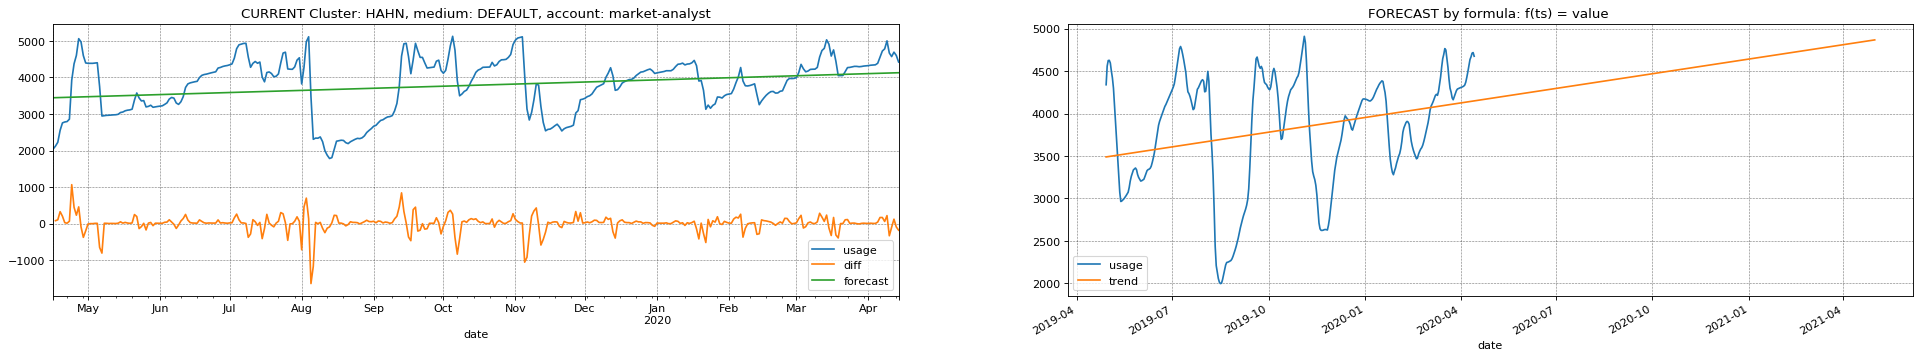

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.2602999324940673,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.102415839272919}


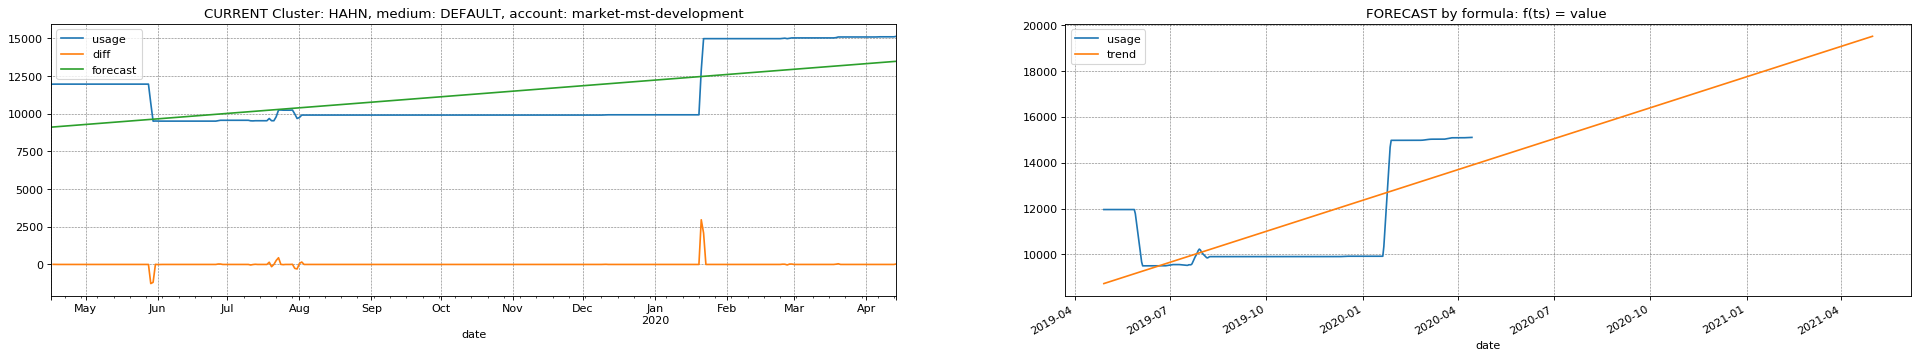

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.23408052793343978,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.3990140802594702}


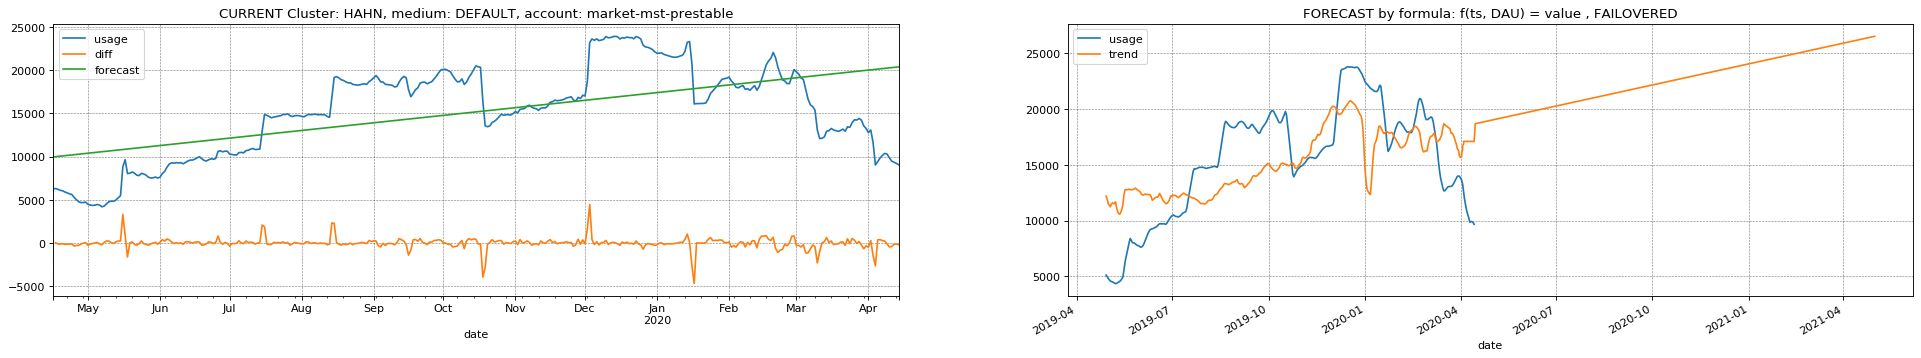

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.5571928653069539}


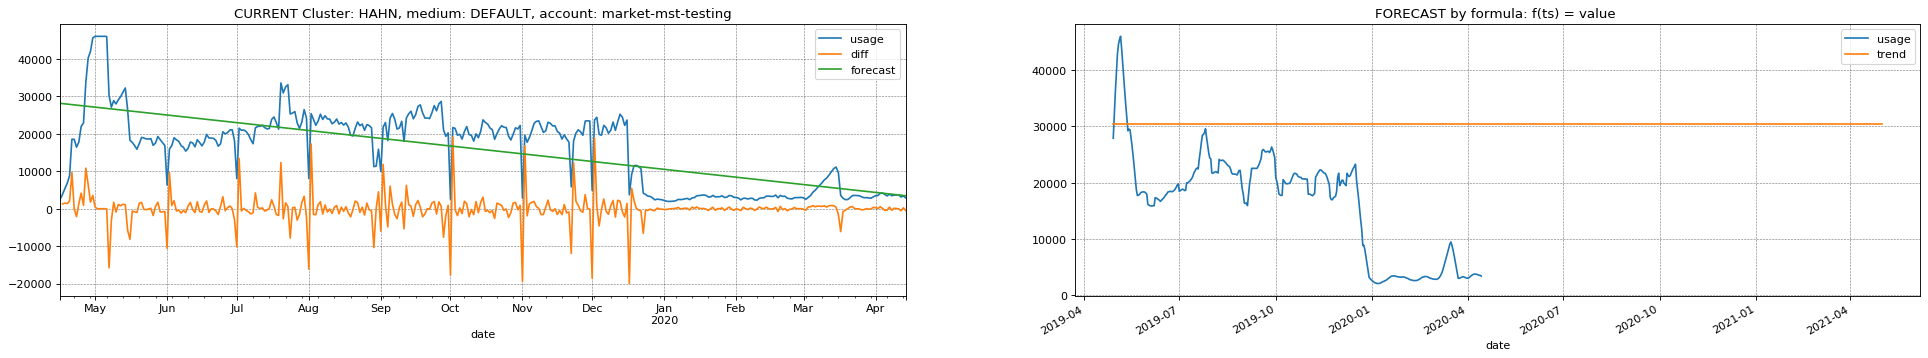

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.29902772915602915,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: -0.5811102695740693}


HAHN SSD usage: None / None Gb = 0 %


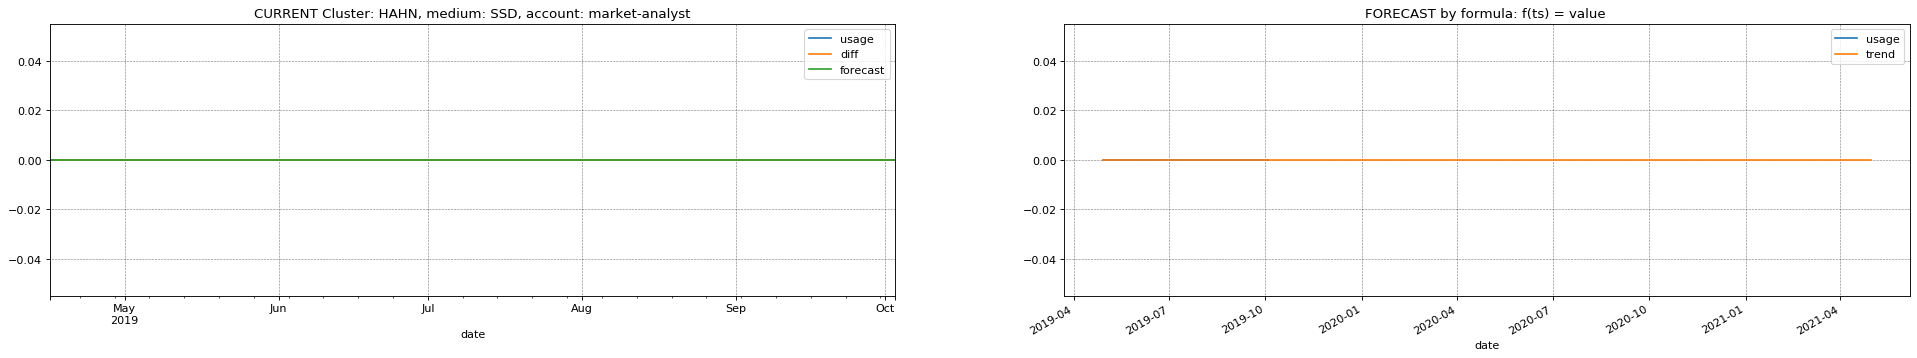

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


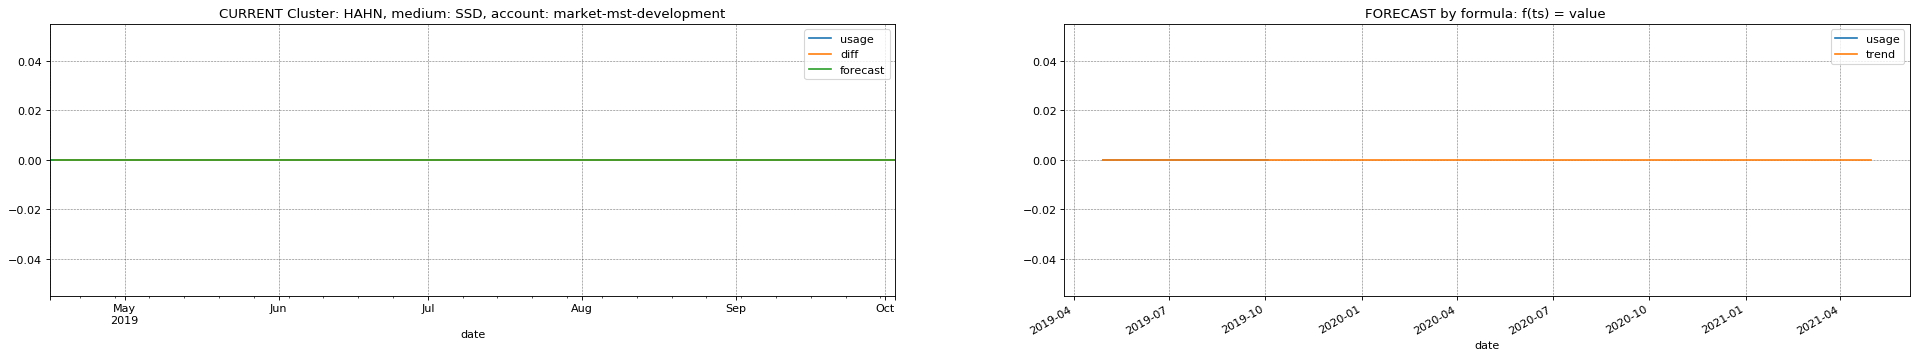

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


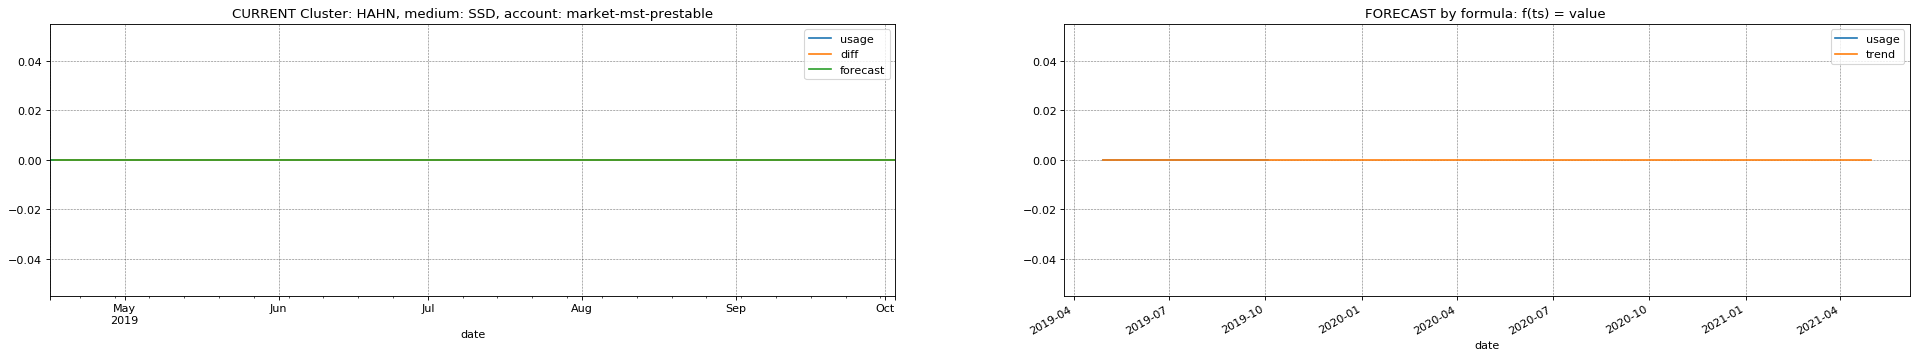

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


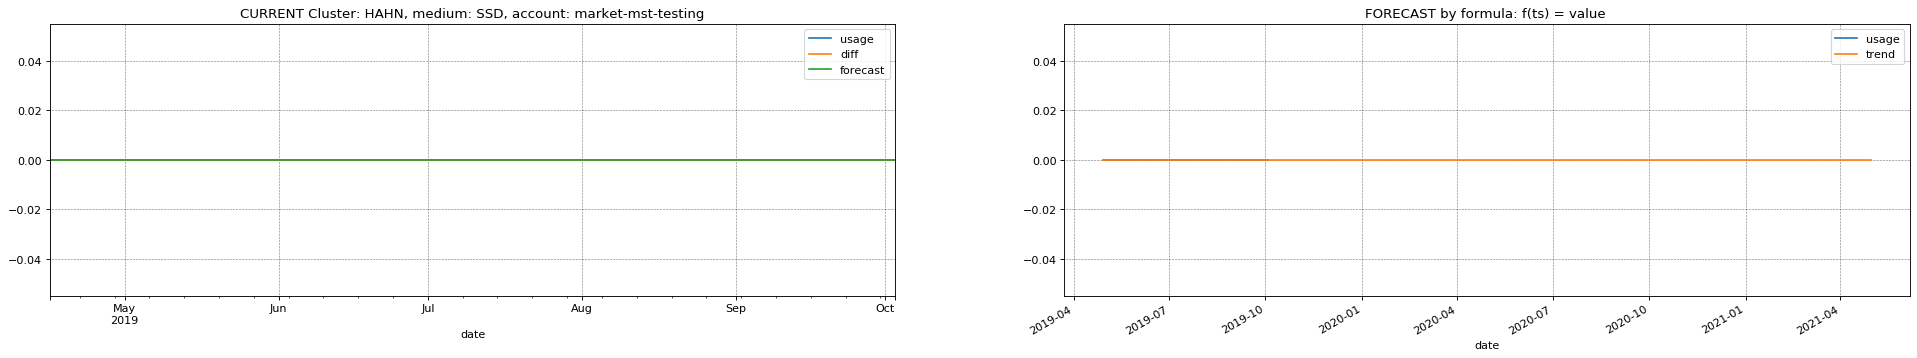

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


ARNOLD DEFAULT usage: 3864 / 373760 Gb = 1.03 %


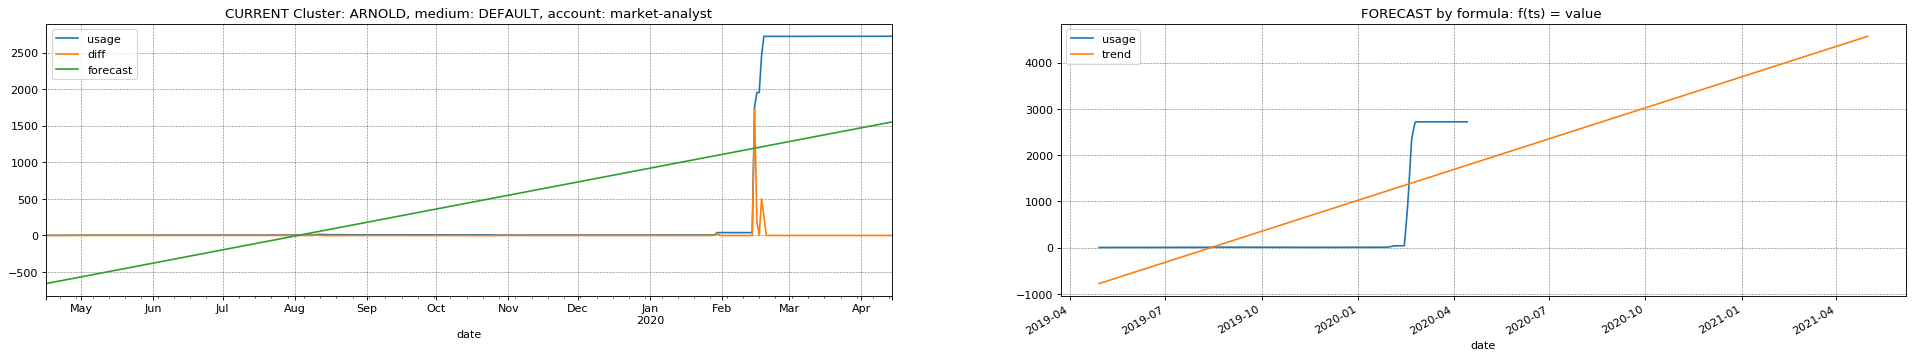

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.311113802578658,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.3819171938018892}


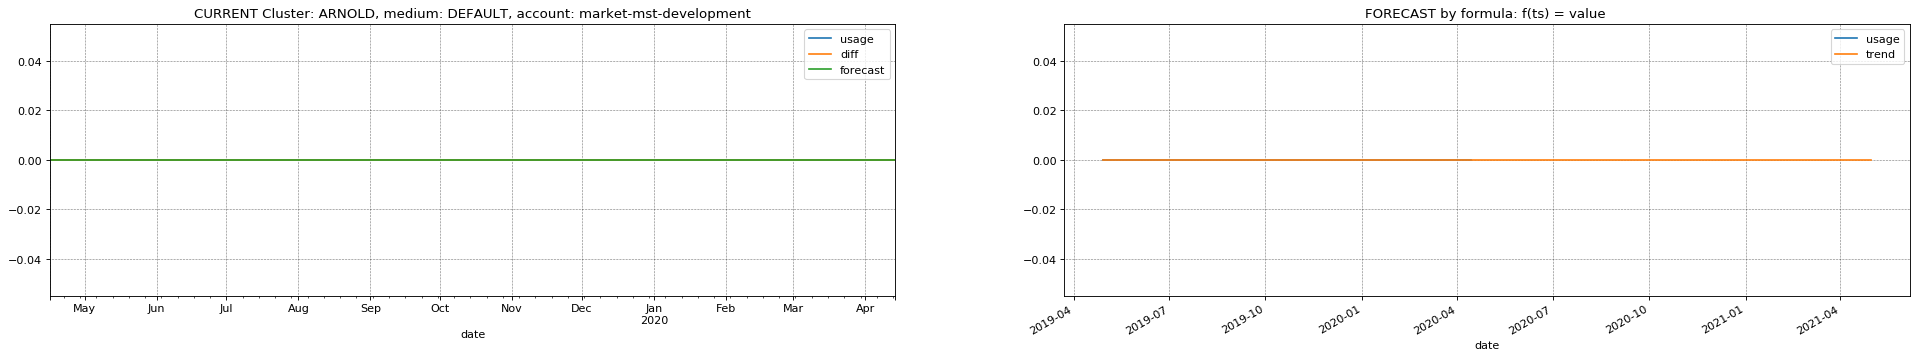

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


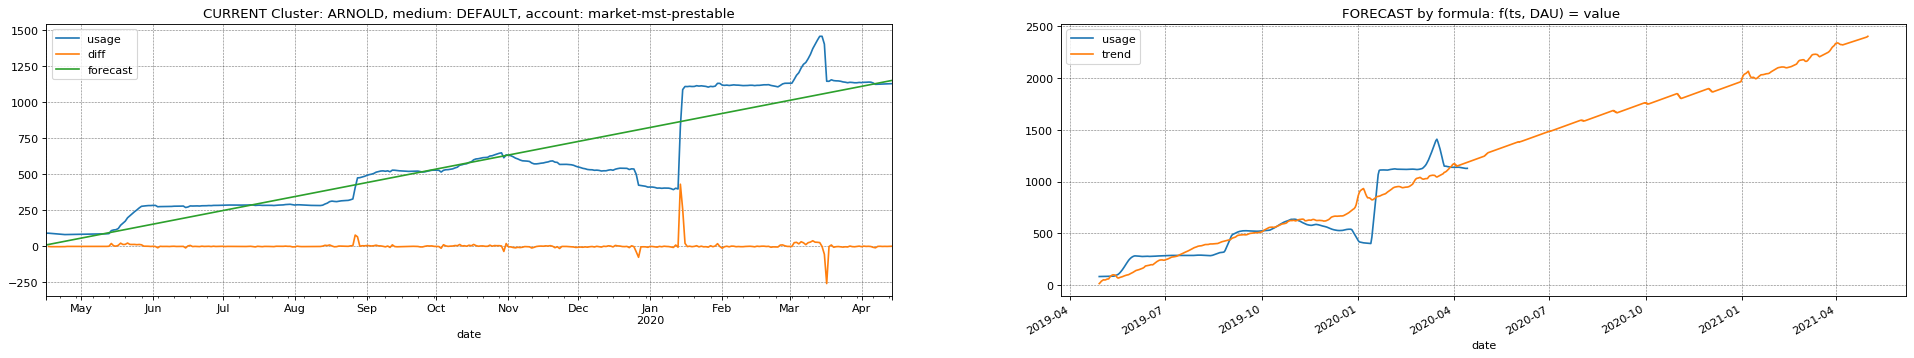

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.6921125978256042}


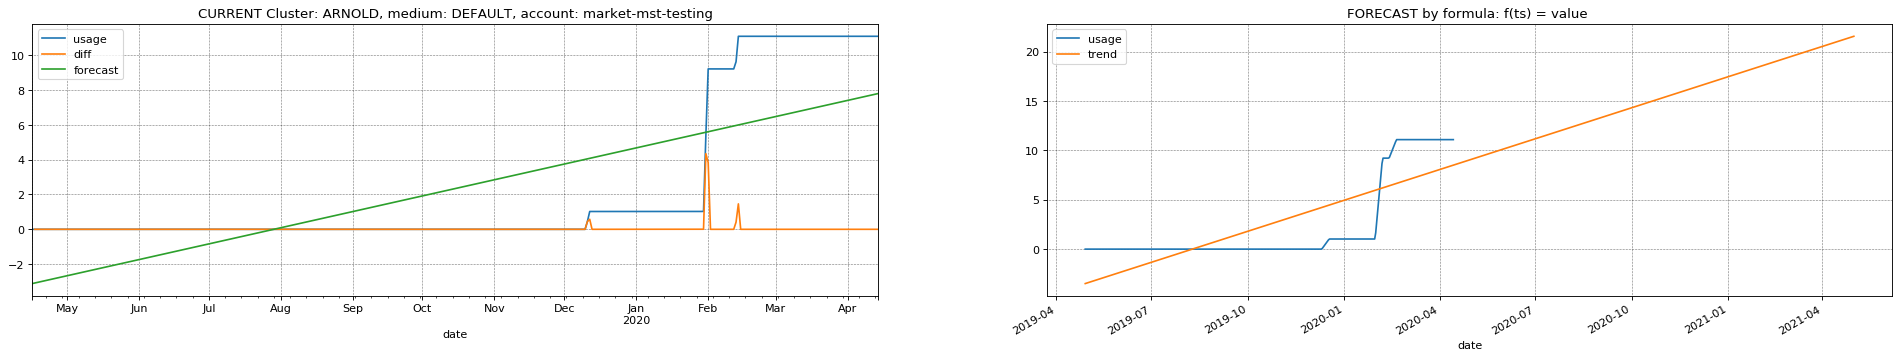

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.2783538164438737,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.4648977407078758}


ARNOLD SSD usage: None / None Gb = 0 %


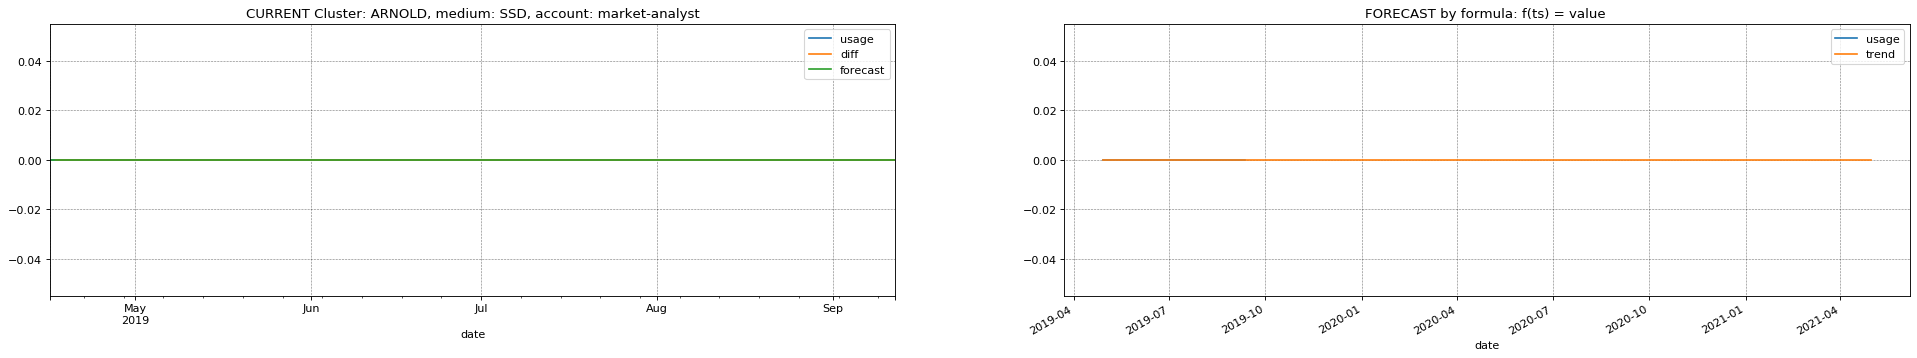

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


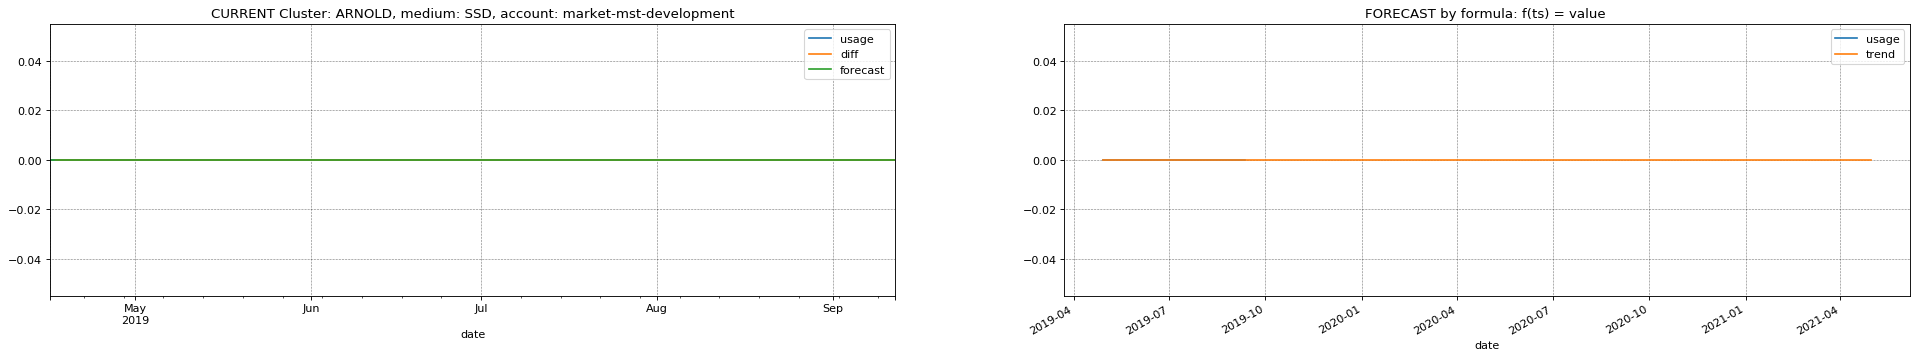

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


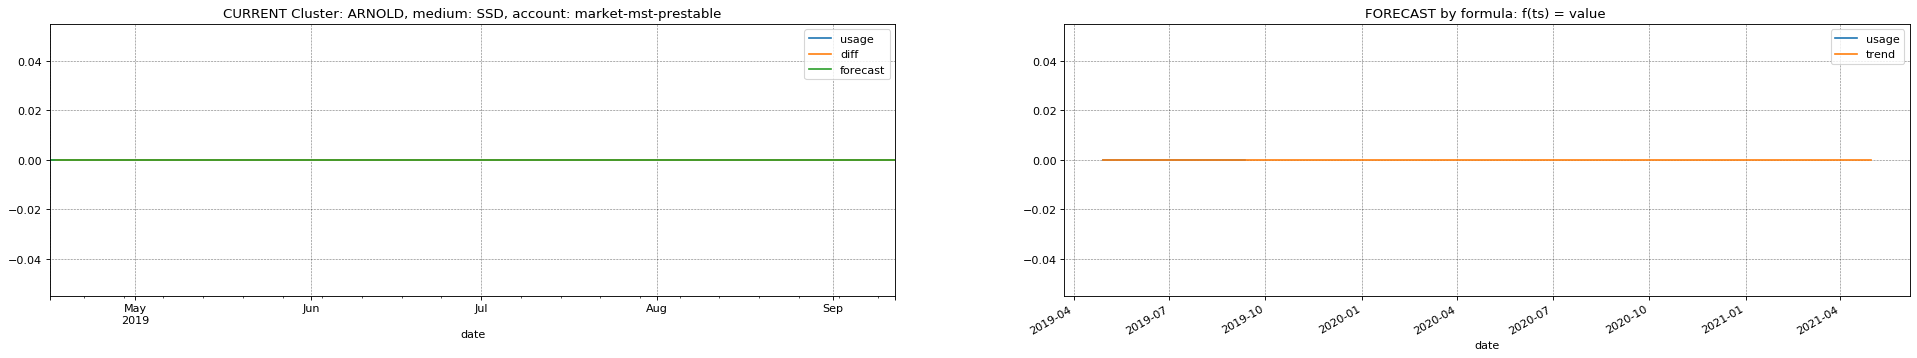

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


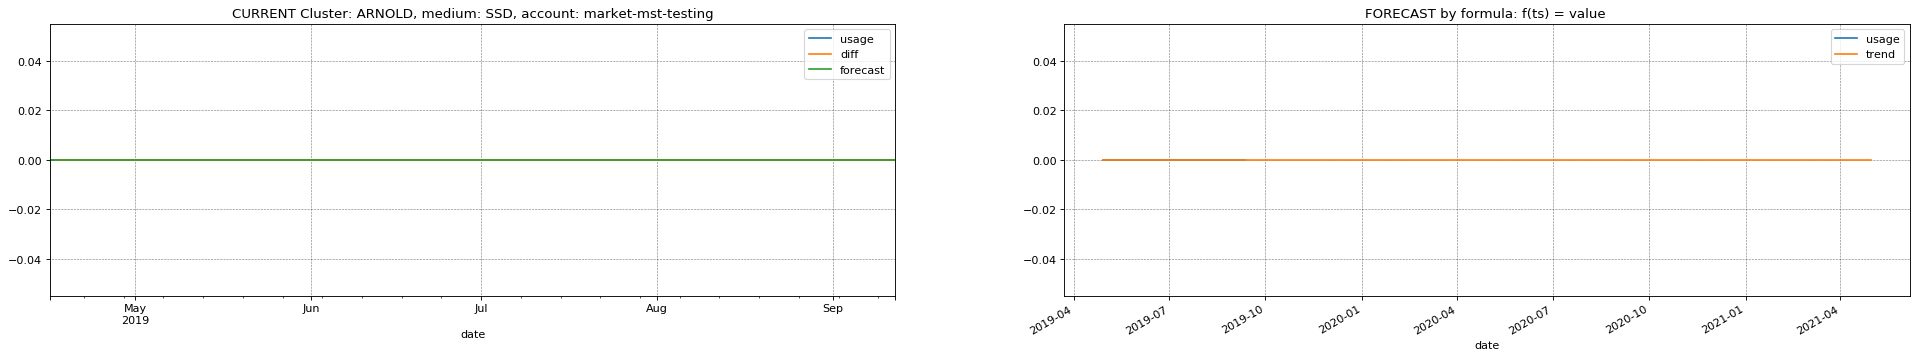

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: nan,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: nan}


SENECA_SAS DEFAULT usage: 345 / 4946 Gb = 6.98 %


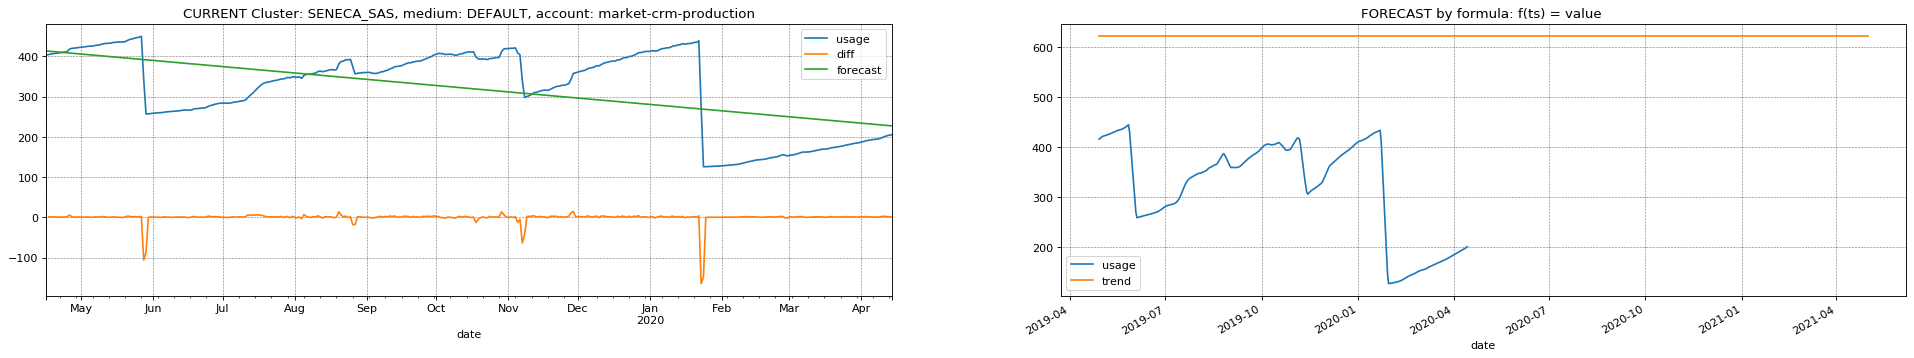

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.018828596803903978,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: -0.31751706986866873}


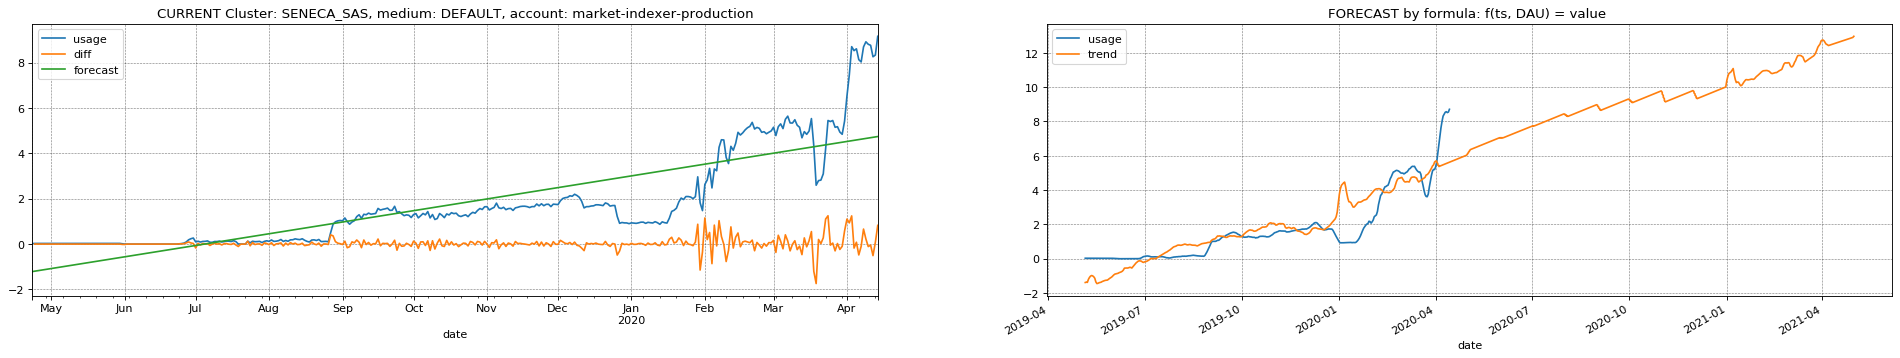

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.5779412411322523}


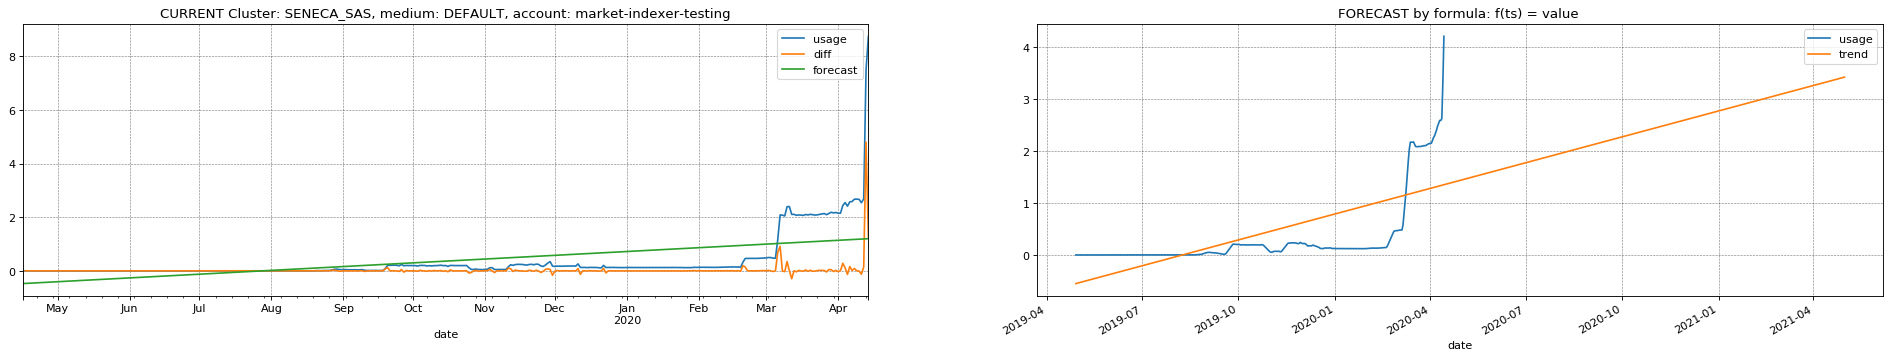

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.48253568119485934,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.38389656042152426}


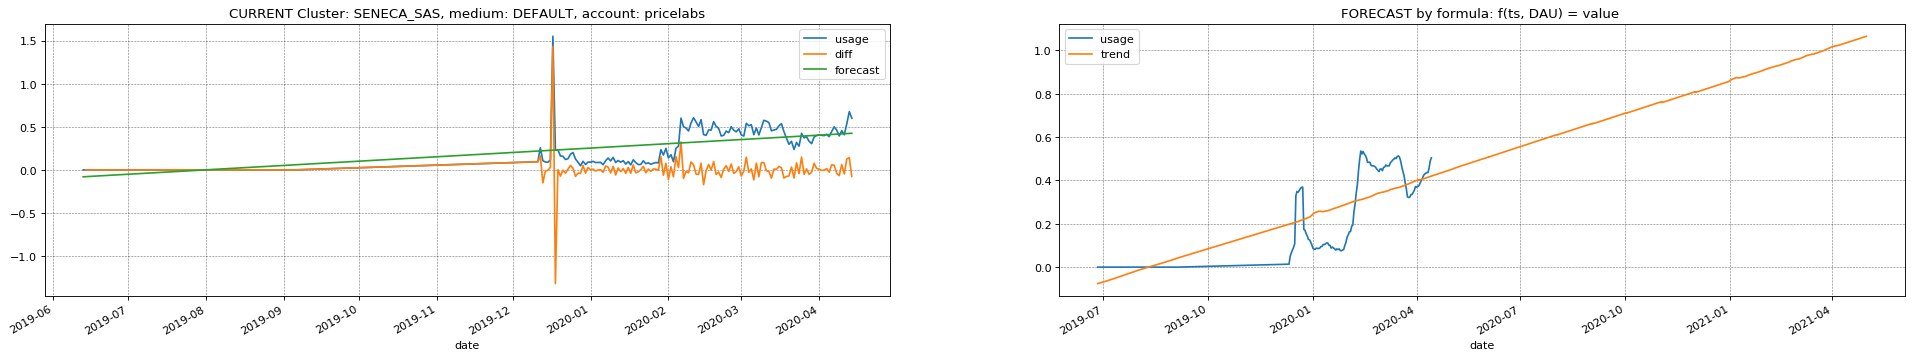

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.6755538712140696}


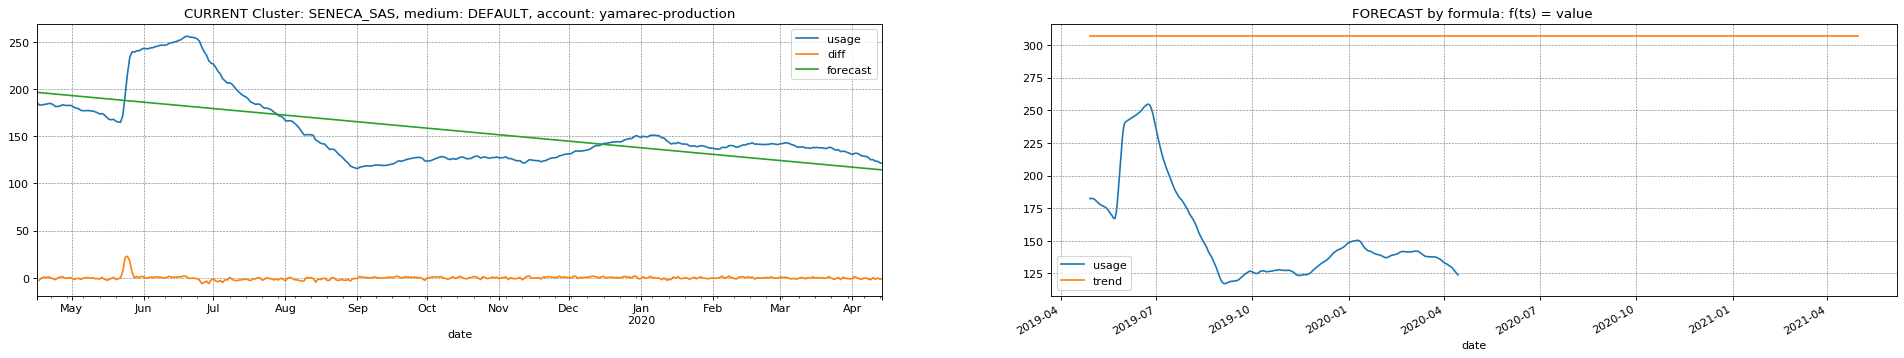

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.23921903587984414,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: -0.6010800578186215}


SENECA_SAS SSD usage: 1378 / 7304 Gb = 18.87 %


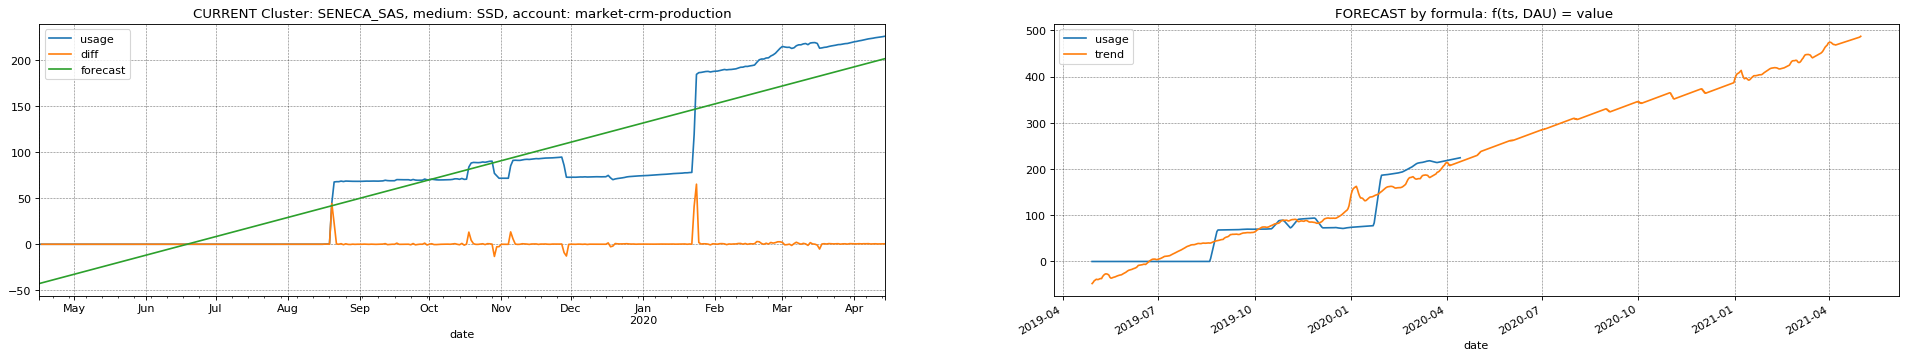

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.6892181305208384}


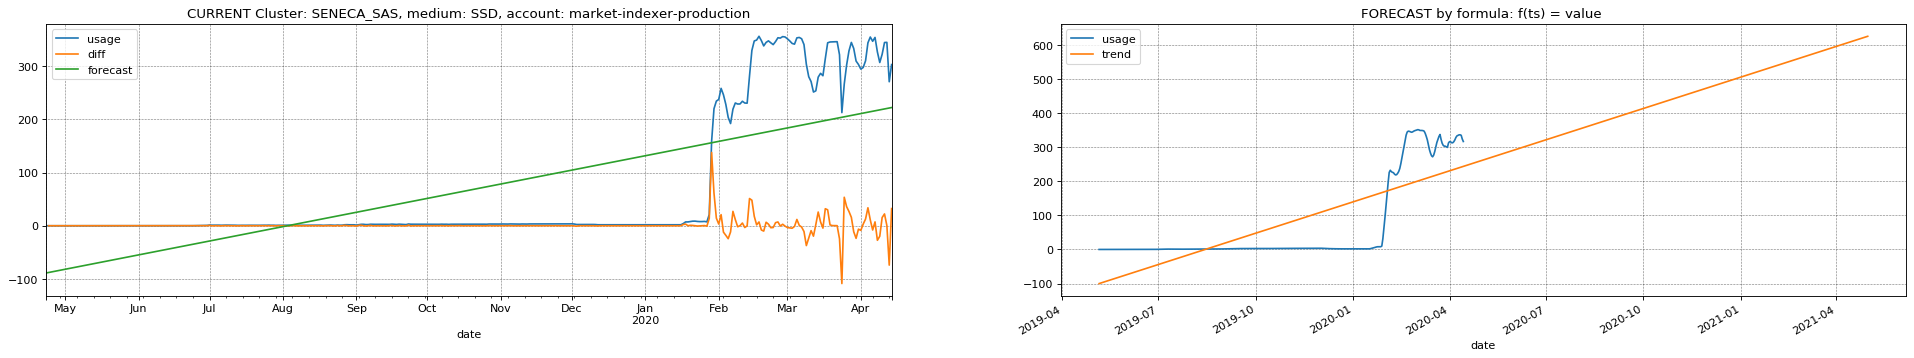

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.26624521648475724,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.4313615079687915}


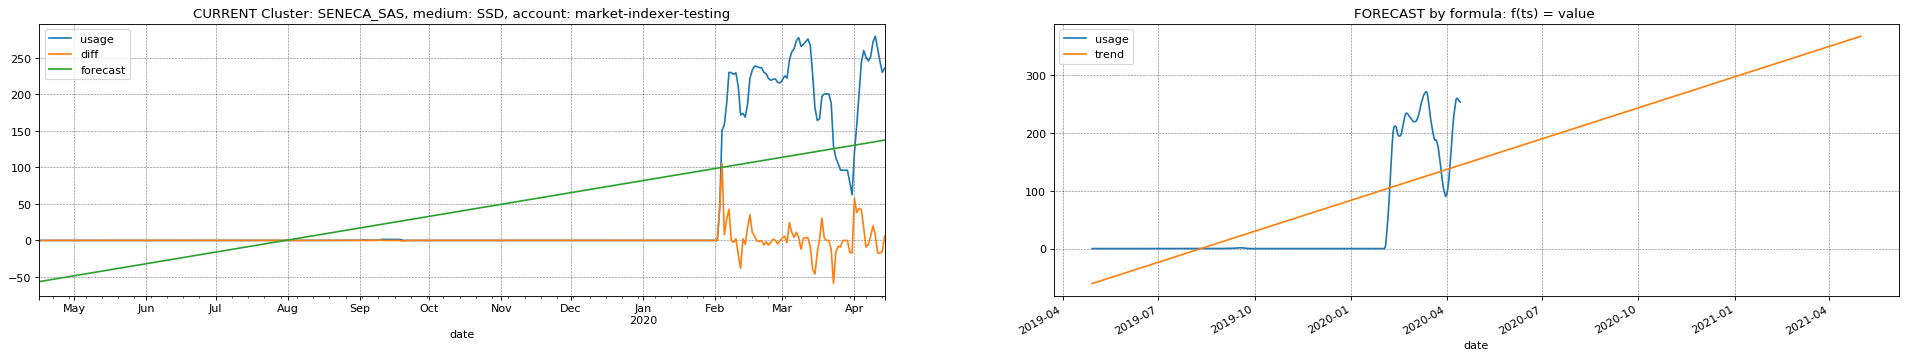

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: -0.2609772089069892,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.42535147471671625}


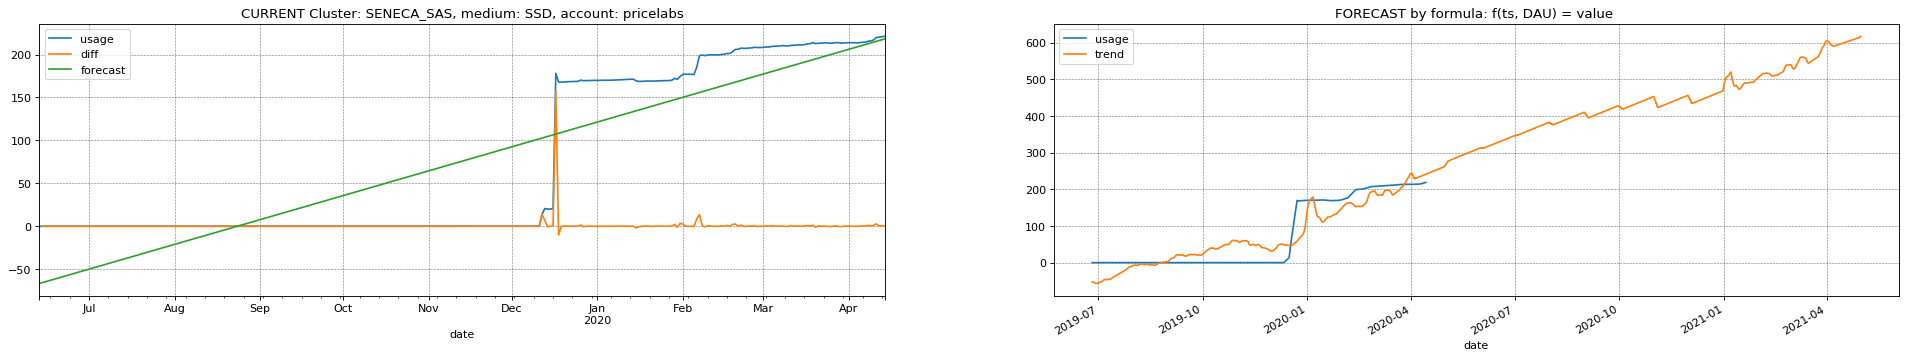

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.511233339493455}


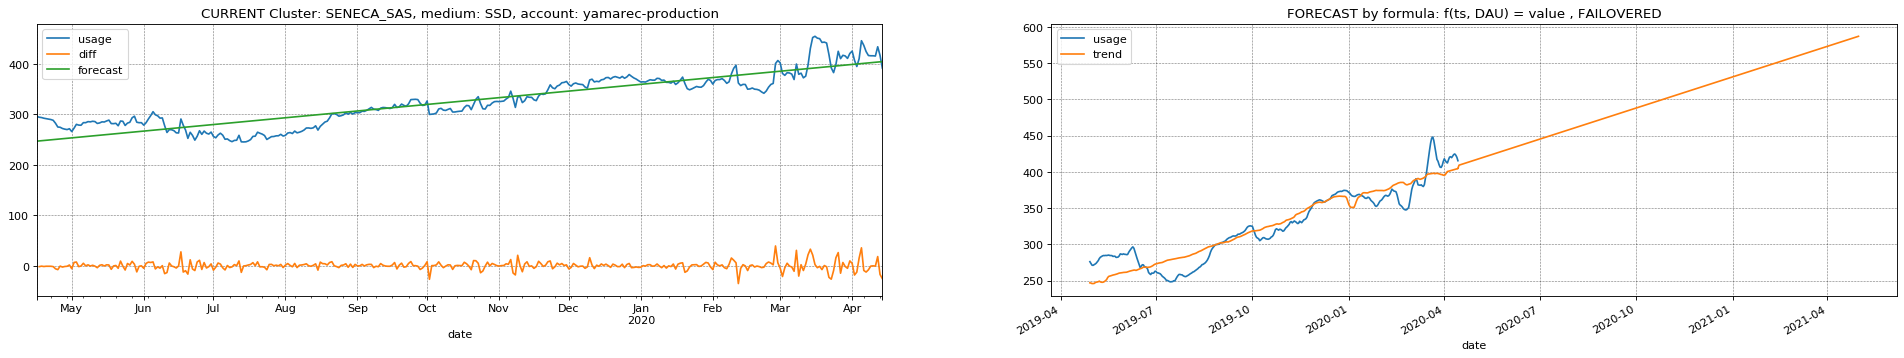

Correlations: {<Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.8130769975294233}


In [12]:
disk_forecast = get_disk_forecast(predictor=predictor,
                                  formula=formula,
                                  formula_strategy=formula_strategy,
                                  features=features,
                                  values=['usage'], # в дифах кореляций не ищем
                                  window=Window(),
                                  decreasing_base_function=decreasing_base_function,
                                  decreasing_reserve=decreasing_reserve,
                                  cluster_accounts=cluster_accounts,
                                  date_start=date_start,
                                  date_end=date_end,
                                  verbose=verbose,
                                  grid=grid,
                                  forecast_end_date=forecast_date
                                 )

In [13]:
disk_forecast_df = pd.DataFrame(disk_forecast).set_index(['cluster', 'account', 'medium'])
disk_forecast_df

predicted_usage_gb      reason  \
cluster    account                   medium                                    
HAHN       market-analyst            DEFAULT                4869  CUMULATIVE   
           market-mst-development    DEFAULT               19504  CUMULATIVE   
           market-mst-prestable      DEFAULT               26543         DAU   
           market-mst-testing        DEFAULT               30499  CUMULATIVE   
           market-analyst            SSD                       0  CUMULATIVE   
           market-mst-development    SSD                       0  CUMULATIVE   
           market-mst-prestable      SSD                       0  CUMULATIVE   
           market-mst-testing        SSD                       0  CUMULATIVE   
ARNOLD     market-analyst            DEFAULT                4573  CUMULATIVE   
           market-mst-development    DEFAULT                   0  CUMULATIVE   
           market-mst-prestable      DEFAULT                2425         DAU   
           market-mst-testing        DEFAULT                  22  CUMULATIVE   
           market-analyst            SSD                       0  CUMULATIVE   
           market-mst-development    SSD                       0  CUMULATIVE   
           market-mst-prestable      SSD                       0  CUMULATIVE   
           market-mst-testing        SSD                       0  CUMULATIVE   
SENECA_SAS market-crm-production     DEFAULT                 622  CUMULATIVE   
           market-indexer-production DEFAULT                  14         DAU   
           market-indexer-testing    DEFAULT                   4  CUMULATIVE   
           pricelabs                 DEFAULT                   2         DAU   
           yamarec-production        DEFAULT                 307  CUMULATIVE   
           market-crm-production     SSD                     494         DAU   
           market-indexer-production SSD                     626  CUMULATIVE   
           market-indexer-testing    SSD                     368  CUMULATIVE   
           pricelabs                 SSD                     630         DAU   
           yamarec-production        SSD                     587         DAU   

                                              usage_gb  quota_gb  
cluster    account                   medium                       
HAHN       market-analyst            DEFAULT      4421      5120  
           market-mst-development    DEFAULT     15129     15360  
           market-mst-prestable      DEFAULT      9064    307200  
           market-mst-testing        DEFAULT      2925     46080  
           market-analyst            SSD             0         0  
           market-mst-development    SSD             0         0  
           market-mst-prestable      SSD             0         0  
           market-mst-testing        SSD             0         0  
ARNOLD     market-analyst            DEFAULT      2723      5120  
           market-mst-development    DEFAULT         0     15360  
           market-mst-prestable      DEFAULT      1130    307200  
           market-mst-testing        DEFAULT        12     46080  
           market-analyst            SSD             0         0  
           market-mst-development    SSD             0         0  
           market-mst-prestable      SSD             0         0  
           market-mst-testing        SSD             0         0  
SENECA_SAS market-crm-production     DEFAULT       206       450  
           market-indexer-production DEFAULT        10       300  
           market-indexer-testing    DEFAULT         9      1024  
           pricelabs                 DEFAULT         1       100  
           yamarec-production        DEFAULT       122      3072  
           market-crm-production     SSD           226      1334  
           market-indexer-production SSD           303      1224  
           market-indexer-testing    SSD           237      1174  
           pricelabs                 SSD           222       50

In [3]:
from market.sre.tools.capacity.preorder.v2020apr.additional.RTC.src.forecast.ForecastDAO import ForecastDAO, ForecastTable

forecast_dto = []

# for key, value in disk_forecast_df.query("predicted_usage_gb > 0").iterrows():
for key, value in disk_forecast_df.iterrows():
    cluster, account, medium = key
    predicted_usage_gb = value.predicted_usage_gb
    quota_gb = value.quota_gb
    usage_gb = value.usage_gb
    reason = value.reason
    
    if medium == 'DEFAULT':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            hdd_quota_gb=quota_gb,
            hdd_usage_gb=usage_gb,
            predicted_hdd_usage_gb=predicted_usage_gb
        )
    elif medium == 'SSD':
        disk_quota=YtOrderRequestFileItemDiskQuota(
            accounts=[account],
            ssd_quota_gb=quota_gb,
            ssd_usage_gb=usage_gb,
            predicted_ssd_usage_gb=predicted_usage_gb
        )
    else:
        raise
    
    resource_info = whois.get_info(Cloud.YT, clean_YT_account(account))
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       disk_quota=disk_quota)
    
    result_dir_path = capacity_path / preorder_key / result_dir / (f"{resource_info['department']}/{Cloud.YT}")
    Path(result_dir_path).mkdir(parents=True, exist_ok=True)
    file_path = result_dir_path / (f"disk-{cluster}-{account}-{medium}.yaml")
    
    
    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket='',
        contacts={},
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(target_dir / f'{service_file_name}_disk.yaml'),
        reason=Reason.from_str(reason),
        generated=True,
        source_meta={'kpi': kpi_key}).dump_to_file()
    forecast_disk=ForecastDAO(
            metric = str(medium),
            environment = str(account.split('-')[-1]),
            kpi = kpi_key,
            cloud = "YT",
            abc_service = department_info.abc_slug,
            entity = str(account),
            forecast_start_date = forecast_start_date,
            forecast_end_date = forecast_end_date,
            history_start_date = history_start_date,
            history_end_date = history_end_date,
            result_df = value.trend,
            result_by_date = predicted_usage_gb if not np.isnan(predicted_usage_gb) else 0,
            preorder_id = 'feb21',
            source_meta = {'cluster': cluster}
        )
    forecast_dto.append(forecast_disk)
ForecastDAO.save_forecast(client = ForecastDAO.get_client(), forecasts=forecast_dto, table=ForecastTable('yt_accounts').get_forecast_table_path())

ModuleNotFoundError: No module named 'market'

In [1]:
df = disk_forecast_df.rename(columns={
                   'quota': 'current_allocation', 
                   'predicted_usage_gb': 'future_allocation',
                    'reason': 'correlation'}).reset_index()
df['service'] = df['cluster'] + '_' + df['account'] + '_' + df['medium']
df.to_json(target_dir / f'{service_file_name}_disk.json')

NameError: name 'disk_forecast_df' is not defined

### CPU

In [15]:
label = 'mst'

_hahn_pools_list = [pool for pool in hahn_pools_list if label in pool and env in pool]
_arnold_pools_list = [pool for pool in arnold_pools_list if label in pool and env in pool]

cluster_pools = {
#     Cluster.HAHN: _hahn_pools_list,
    Cluster.HAHN: ['market-production-mstat-tm-testing'],
#     Cluster.ARNOLD: _arnold_pools_list
    Cluster.ARNOLD: ['market-production-mstat-tm-testing'],
}

print(cluster_pools)

{<Cluster.HAHN: 'hahn'>: ['market-production-mstat-tm-testing'], <Cluster.ARNOLD: 'arnold'>: ['market-production-mstat-tm-testing']}


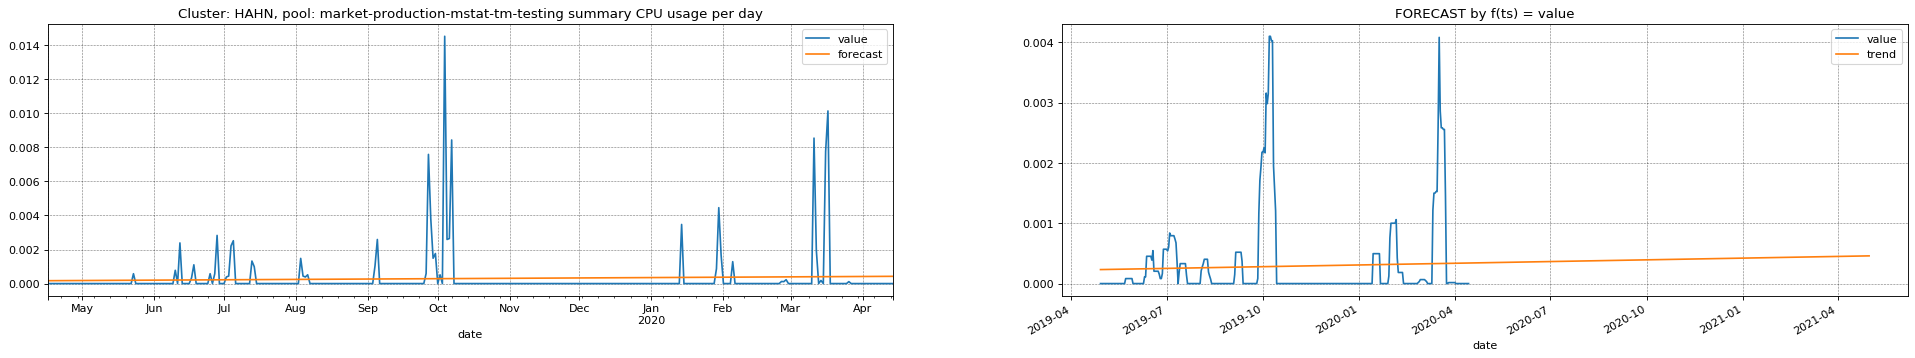

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.13741312168348516,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.019129484818503316,
 <Formula.F_TS_DAU_eq_DIFF: 'f(ts, DAU) = diff'>: -0.002873668754954522,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: 0.015440772927773835}
Базовый прогноз: 0.0004592769326161629 ядер


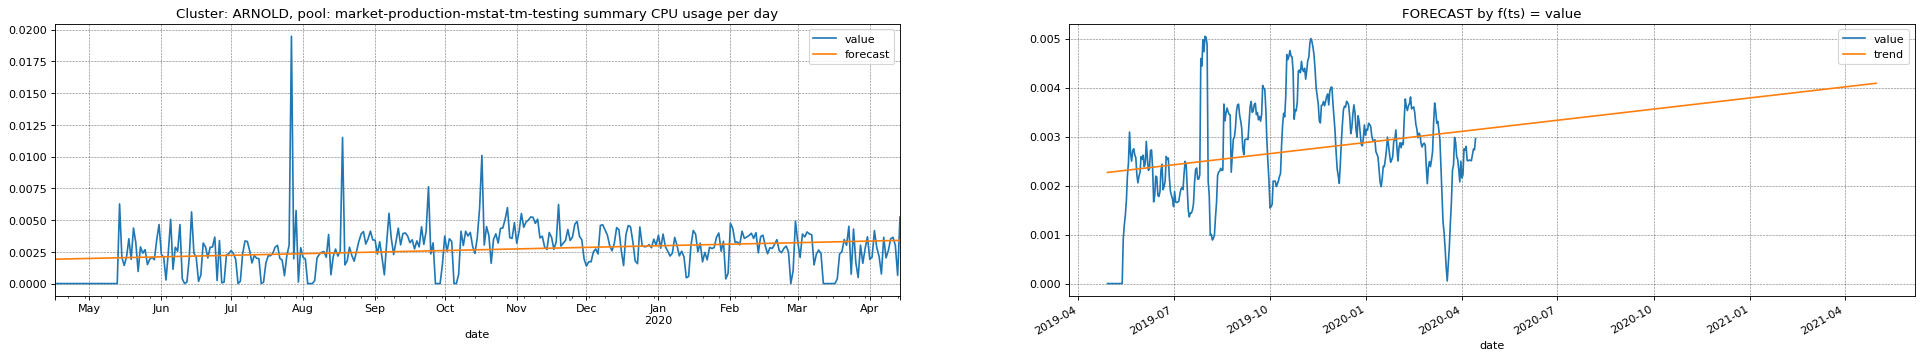

Correlations: {<Formula.F_TS_OFFERS_eq_VALUE: 'f(ts, offers_count) = value'>: 0.02817632711403885,
 <Formula.F_TS_DAU_eq_VALUE: 'f(ts, DAU) = value'>: 0.3264369386316663,
 <Formula.F_TS_DAU_eq_DIFF: 'f(ts, DAU) = diff'>: -0.042878610199693724,
 <Formula.F_TS_OFFERS_eq_DIFF: 'f(ts, offers_count) = diff'>: -0.01550452339598852}
Базовый прогноз: 0.0040875499247899 ядер


In [16]:
cpu_forecast = get_cpu_forecast(predictor=predictor,
                                cluster_pools=cluster_pools,
                                formula=formula,
                                formula_strategy=formula_strategy,
                                features=features,
                                window=Window(),
                                decreasing_base_function=decreasing_base_function,
                                decreasing_reserve=decreasing_reserve,
                                consider_peaks=consider_peaks,
                                date_start=date_start,
                                date_end=date_end,
                                peaks_window_1=30,
                                peaks_window_2=90,
                                verbose=verbose,
                                grid=grid,
                                tail_depth=tail_depth,
                                quantile=quantile,
                                forecast_end_date=forecast_date
                               )

In [6]:
if not cpu_forecast:
    cpu_forecast = pd.DataFrame.from_records([{'cluster':'HAHN', 'pool':'lalala', 'predicted_usage': 0, 'reason': 'CUMULATIVE', 'peak_coef':0,'usage':0,'quota':0}])
cpu_forecast_df = pd.DataFrame(cpu_forecast).set_index(['cluster', 'pool'])
cpu_forecast_df

NameError: name 'cpu_forecast' is not defined

In [1]:
forecast_dto=[]

for key, value in cpu_forecast_df.query("predicted_usage > 0").iterrows():
    cluster, pool = key
    predicted_usage = value.predicted_usage
    quota = value.quota
    usage = value.usage
    peak_coef = value.peak_coef
    reason = value.reason
    
    cpu_quota=YtOrderRequestFileItemCpuQuota(
        pools=[pool],
        cpu_quota=quota,
        cpu_usage=usage,
        predicted_cpu_usage=predicted_usage,
        cpu_peak_coef=peak_coef
    )
    
    resource_info = whois.get_info(Cloud.YT, pool)
    department_info = DepartmentInfo.from_file(capacity_path / preorder_key / 'input_data/orders', resource_info['department'])
    file_item = YTOrderRequestFileItem(cluster=Cluster.from_str(cluster), 
                                       dc=Cluster.from_str(cluster).get_dc(), 
                                       cpu_quota=cpu_quota)
    
    result_dir_path = capacity_path / preorder_key / result_dir / (f"{resource_info['department']}/{Cloud.YT}")
    Path(result_dir_path).mkdir(parents=True, exist_ok=True)
    file_path = result_dir_path / (f"pool-{cluster}-{pool}.yaml")
    
    YTOrderRequestFile(
        department=resource_info['department'],
        cloud=Cloud.YT,
        platform=resource_info['platform'],
        ticket='',
        contacts={},
        deadline=Deadline.EVENLY,
        items=[file_item],
        file_path=str(target_dir / f'{service_file_name}_cpu.yaml'),
        reason=Reason.from_str(reason),
        generated=True,
        source_meta={'kpi': kpi_key}).dump_to_file()
    forecast_cpu=ForecastDAO(
            metric = 'CPU',
            environment = str(account.split('-')[-1]),
            kpi = kpi_key,
            cloud = "YT",
            abc_service = department_info.abc_slug,
            entity = str(pool),
            forecast_start_date = forecast_start_date,
            forecast_end_date = forecast_end_date,
            history_start_date = history_start_date,
            history_end_date = history_end_date,
            result_df = value.trend,
            result_by_date = predicted_usage if not np.isnan(predicted_usage) else 0,
            preorder_id = 'feb21',
            source_meta = {'cluster': cluster}
        )
    forecast_dto.append(forecast_cpu)
ForecastDAO.save_forecast(client = ForecastDAO.get_client(), forecasts=forecast_dto, table=ForecastTable('yt_pools').get_forecast_table_path())

NameError: name 'cpu_forecast_df' is not defined

In [ ]:
df = cpu_forecast_df.rename(columns={
                   'quota': 'current_allocation', 
                   'predicted_usage': 'future_allocation',
                    'reason': 'correlation'}).reset_index()
df['service'] = df['cluster'] + '_' + df['pool'] + '_cpu'
df.to_json(target_dir / f'{service_file_name}_cpu.json')